# The Climate Change Dataset

## Libraries

In [ ]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [ ]:
#load the dataset
df = pd.read_csv('/content/drive/MyDrive/GlobalLandTemperaturesByCity.csv')


# Information of the dataset

In [ ]:
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [ ]:
#The total number of countires / cities / total records
country_counts =df["Country"].unique()
print(len(country_counts),"country")
city_counts =df["City"].unique()
print(len(city_counts),"city")
record_count_major = df.shape[0]
print( record_count_major,"total record")


159 country
3448 city
8599212 total record


# Handeling the missing values

In [ ]:
print(df.isna().sum())

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64


In [ ]:
cols_with_missing = ['AverageTemperature', 'AverageTemperatureUncertainty']
# create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')
df[cols_with_missing] = imputer.fit_transform(df[cols_with_missing])


In [ ]:
# check for missing values
print(df.isna().sum())

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


# Feature engineering

In [ ]:
# create a new column 'Latitude_Direction'
df['Latitude_Direction'] = df['Latitude'].str[-1]
df['Latitude'] = df['Latitude'].str[:-1].astype(float)
# create a new column 'Longitude_Direction'
df['Longitude_Direction'] = df['Longitude'].str[-1]
df['Longitude'] = df['Longitude'].str[:-1].astype(float)
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01            6.068000                       1.737000  Århus   
1  1743-12-01           16.727433                       1.028575  Århus   
2  1744-01-01           16.727433                       1.028575  Århus   
3  1744-02-01           16.727433                       1.028575  Århus   
4  1744-03-01           16.727433                       1.028575  Århus   

   Country  Latitude  Longitude Latitude_Direction Longitude_Direction  
0  Denmark     57.05      10.33                  N                   E  
1  Denmark     57.05      10.33                  N                   E  
2  Denmark     57.05      10.33                  N                   E  
3  Denmark     57.05      10.33                  N                   E  
4  Denmark     57.05      10.33                  N                   E

In [ ]:
#converst the dt column
df.loc[:, 'dt'] = pd.to_datetime(df['dt'])
df.loc[:, 'Year'] = df['dt'].dt.year
df.loc[:, 'Month'] = df['dt'].dt.month

<ipython-input-14-9fd02269e931>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'dt'] = pd.to_datetime(df['dt'])


In [ ]:
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')

In [ ]:
# drop columns
df = df.drop(columns=['Latitude_Direction', 'Longitude_Direction'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 11 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   dt                             datetime64[ns]
 1   AverageTemperature             float64       
 2   AverageTemperatureUncertainty  float64       
 3   City                           object        
 4   Country                        object        
 5   Latitude                       float64       
 6   Longitude                      float64       
 7   Latitude_Direction             object        
 8   Longitude_Direction            object        
 9   Year                           int64         
 10  Month                          int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 721.7+ MB


# top 7 large cities in the world

In [ ]:
# consider only the last 50 year in these cities and 7 largest cities in the world
largest_cities = ['São Paulo', 'Moscow', 'New York', 'Toronto', 'Bombay', 'Shanghai', 'Sydney']
df_city = df[(df['City'].isin(largest_cities)) & (df['dt'] >= '1970-01-01') & (df['dt'] <= '2013-12-31')]
df_city.head()

dt  AverageTemperature  AverageTemperatureUncertainty    City  \
1042056 1970-01-01              24.599                          0.349  Bombay   
1042057 1970-02-01              24.568                          0.596  Bombay   
1042058 1970-03-01              25.658                          0.498  Bombay   
1042059 1970-04-01              27.835                          0.611  Bombay   
1042060 1970-05-01              29.348                          0.329  Bombay   

        Country  Latitude  Longitude Latitude_Direction Longitude_Direction  \
1042056   India     18.48      72.68                  N                   E   
1042057   India     18.48      72.68                  N                   E   
1042058   India     18.48      72.68                  N                   E   
1042059   India     18.48      72.68                  N                   E   
1042060   India     18.48      72.68                  N                   E   

         Year  Month  
1042056  1970      1  
1042057  1970      2  
1042058  1970      3  
1042059  1970      4  
1042060  1970      5

In [ ]:
#The total number of countires / cities / total records in df_city
country_counts =df_city["Country"].unique()
print(len(country_counts),"country")
city_counts =df_city["City"].unique()
print(len(city_counts),"city")
record_count_major = df_city.shape[0]
print( record_count_major,"total record")

7 country
7 city
3675 total record


## Time Series Analysys

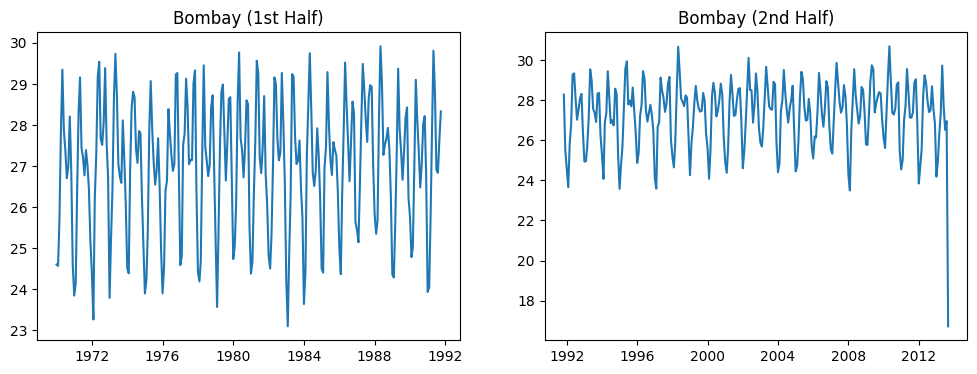

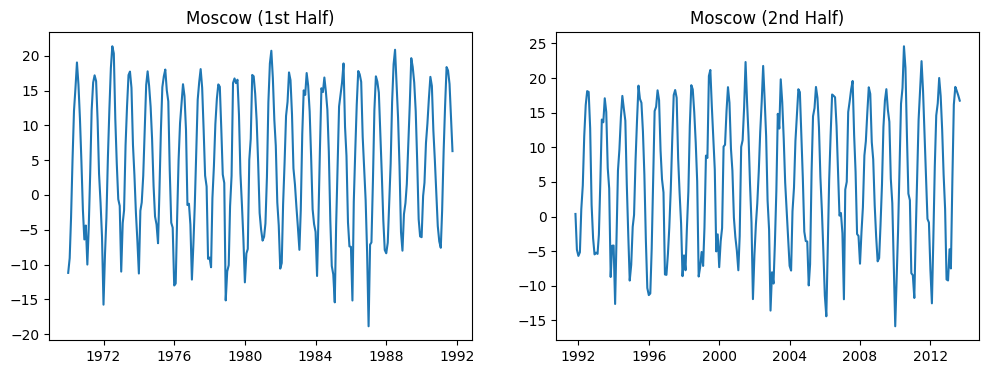

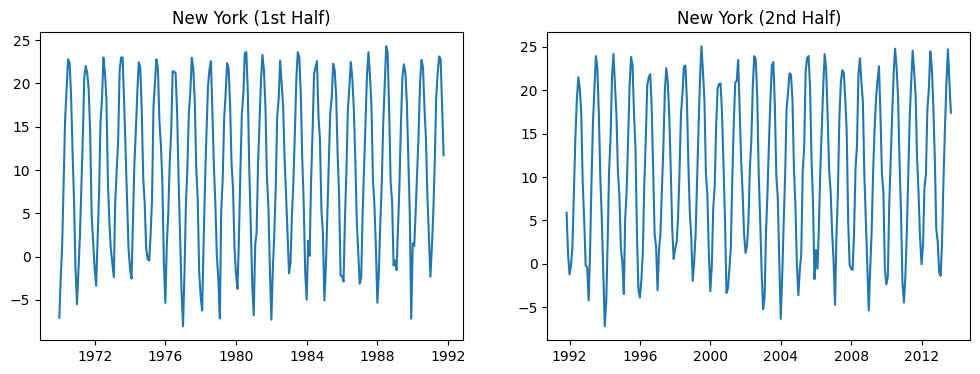

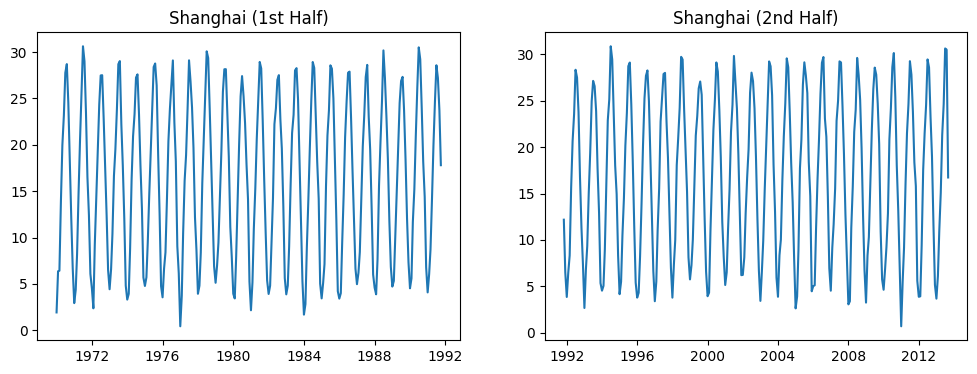

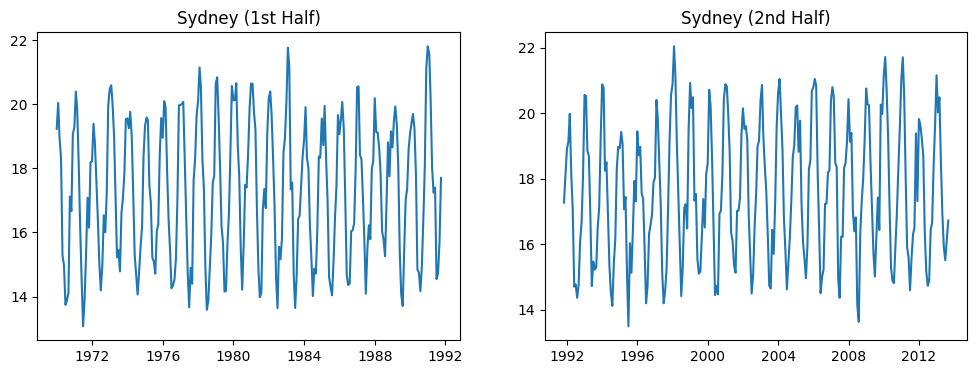

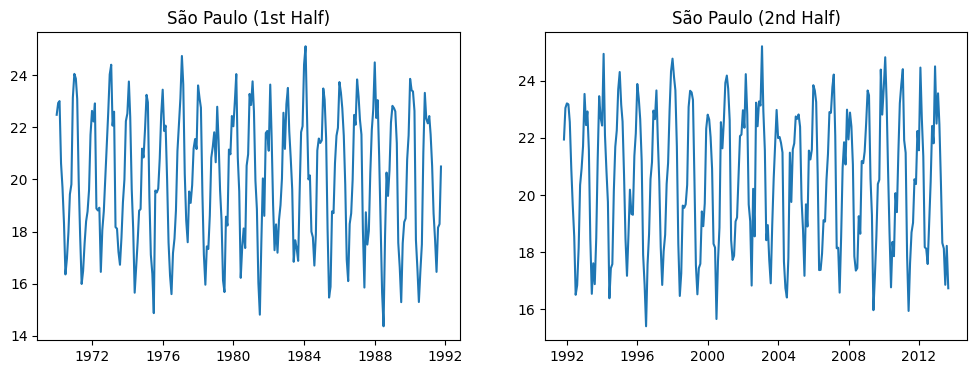

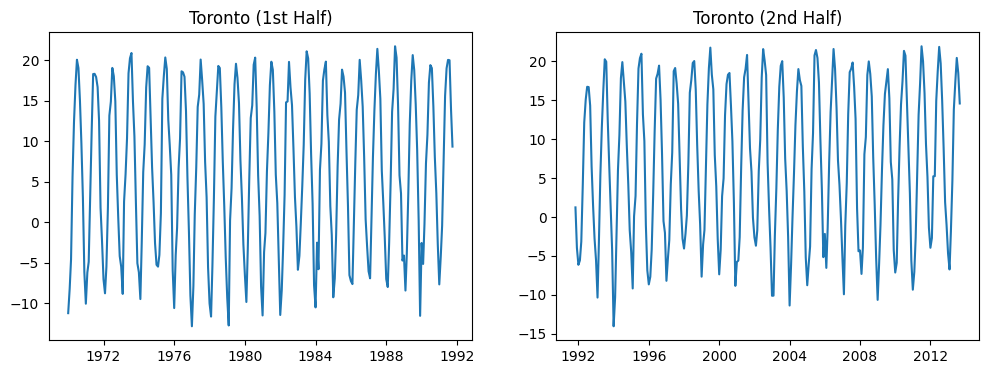

In [ ]:
city_groups = df_city.groupby('City')

for city, group in city_groups:
    n = len(group) // 2
    group1 = group.iloc[:n]
    group2 = group.iloc[n:]
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(group1['dt'], group1['AverageTemperature'])
    axs[0].set_title(f'{city} (1st Half)')
    axs[1].plot(group2['dt'], group2['AverageTemperature'])
    axs[1].set_title(f'{city} (2nd Half)')
    plt.show()


### Split the dataset

In [ ]:
X = df_city[['Year', 'Month', 'Country', 'City']]
y = df_city['AverageTemperature']
X = pd.get_dummies(X, columns=['Country', 'City'])
y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predictive Models

## RandomForestRegressor model

Metrics for Bombay - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.53
RMSE: 0.72
R^2 score: 0.79



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


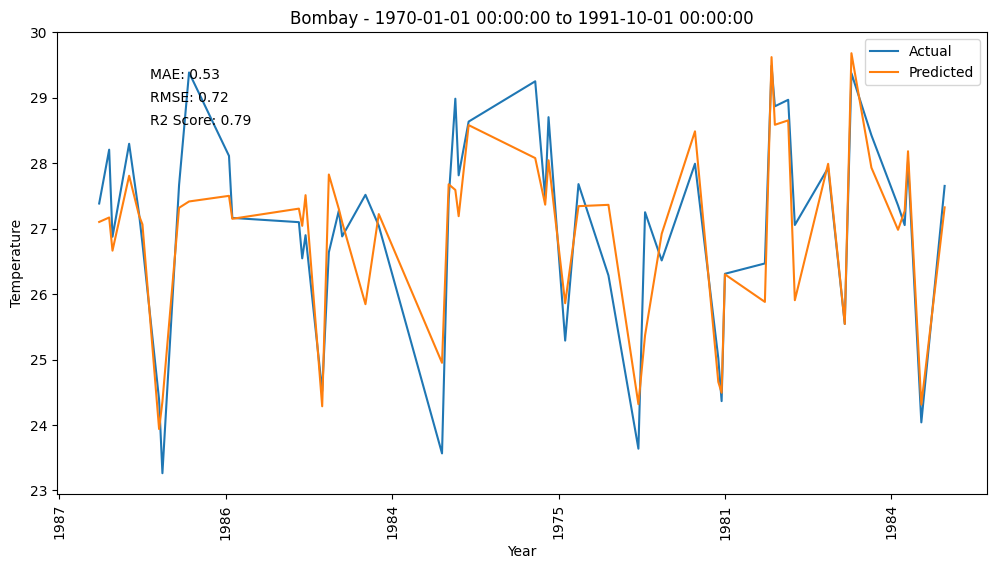

Metrics for Bombay - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.31
RMSE: 0.45
R^2 score: 0.92



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


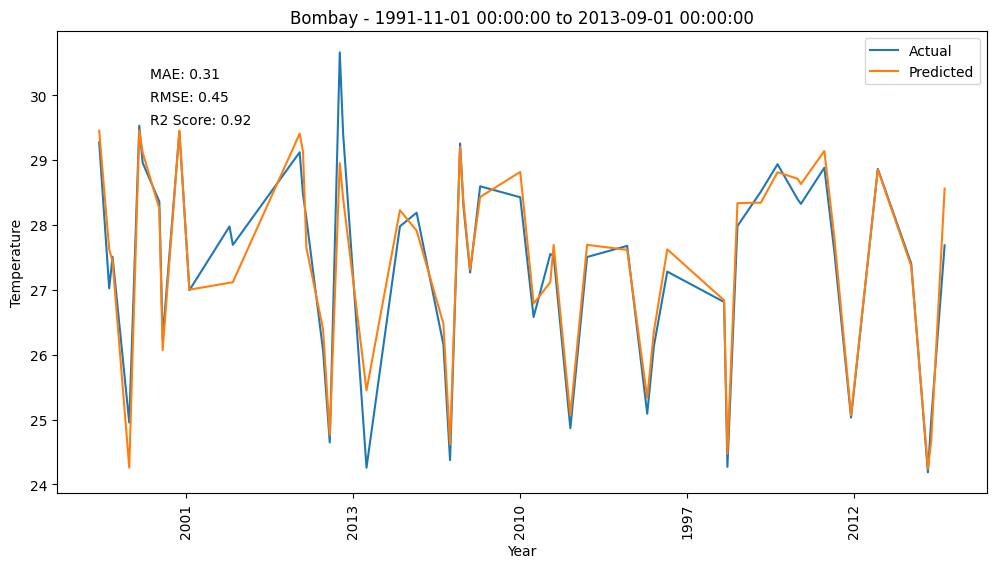

Metrics for Moscow - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.76
RMSE: 2.44
R^2 score: 0.94



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


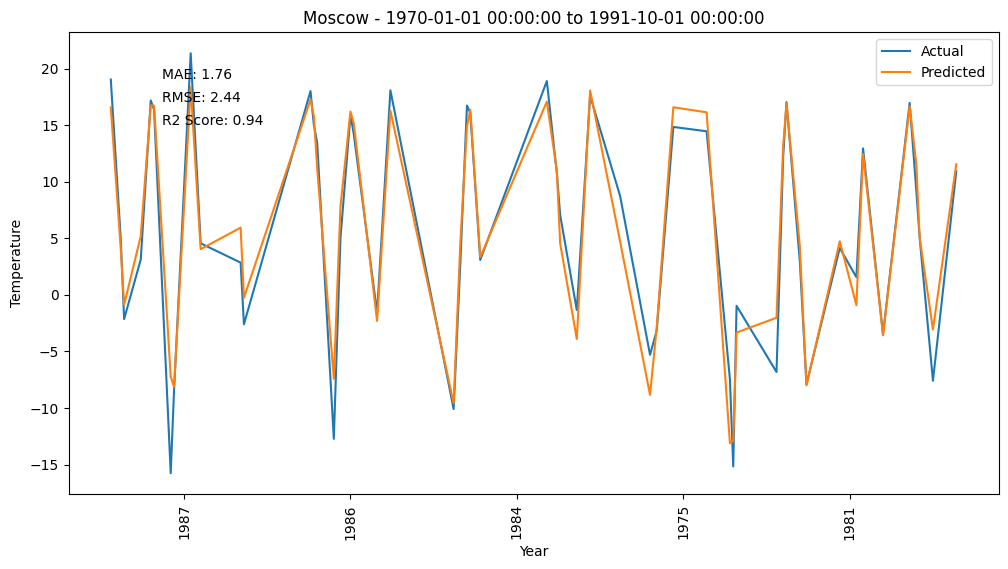

Metrics for Moscow - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.84
RMSE: 2.39
R^2 score: 0.95



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


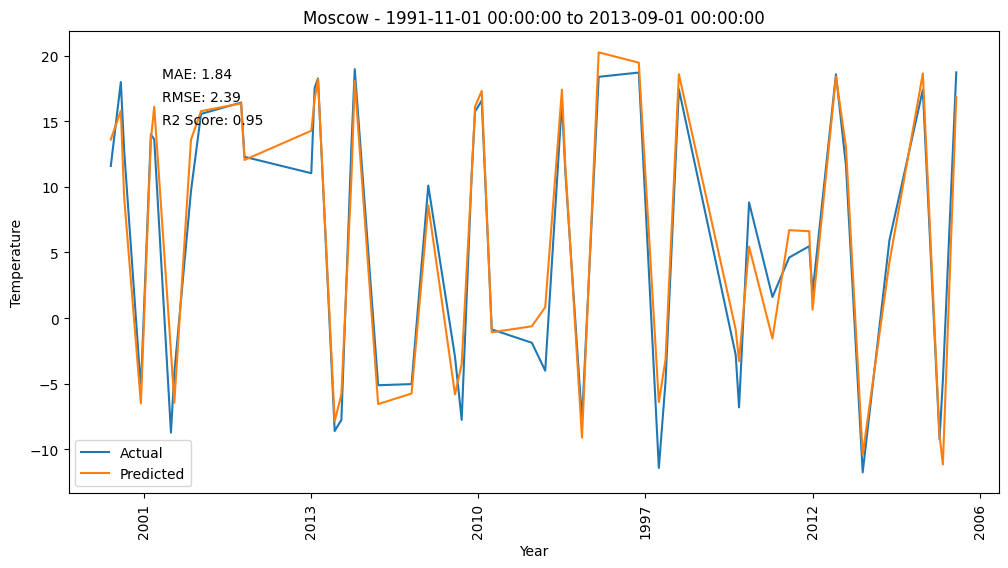

Metrics for New York - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.31
RMSE: 1.66
R^2 score: 0.97



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


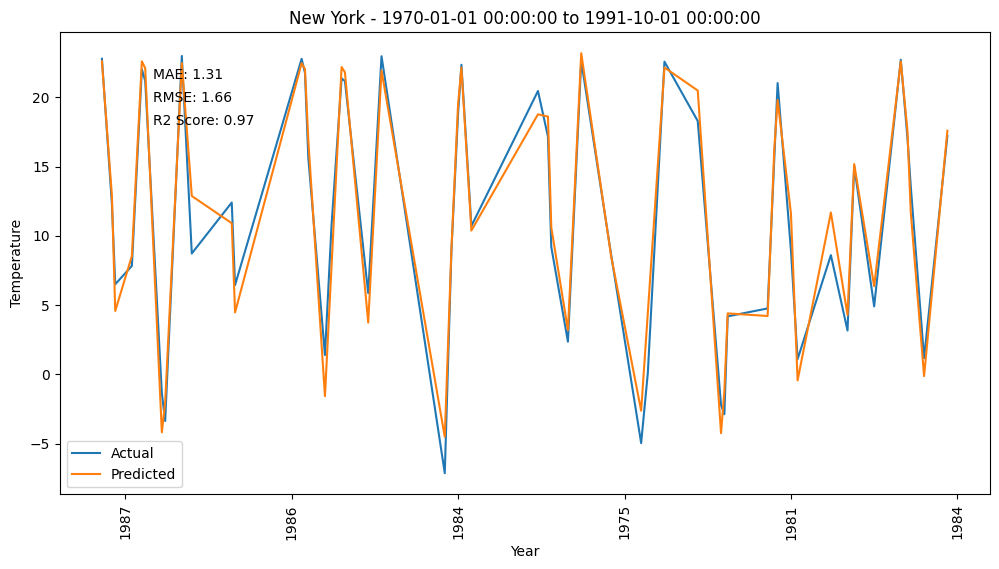

Metrics for New York - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.26
RMSE: 1.64
R^2 score: 0.97



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


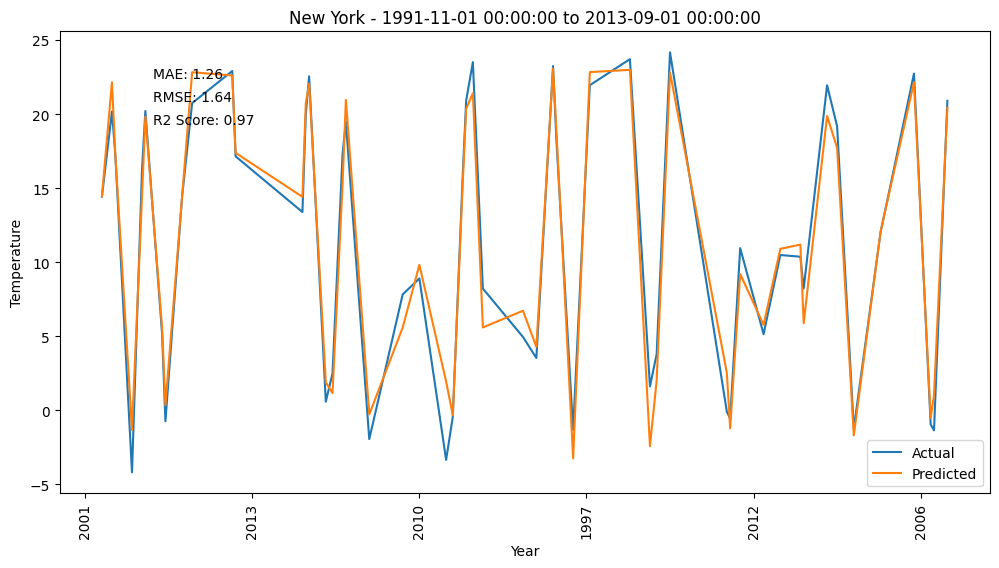

Metrics for Shanghai - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.01
RMSE: 1.25
R^2 score: 0.98



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


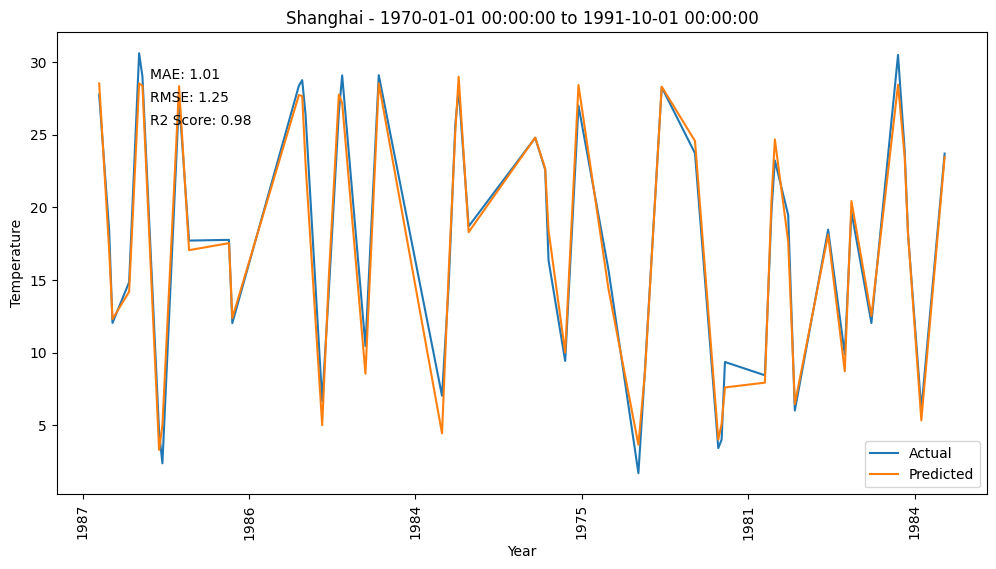

Metrics for Shanghai - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.94
RMSE: 1.20
R^2 score: 0.98



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


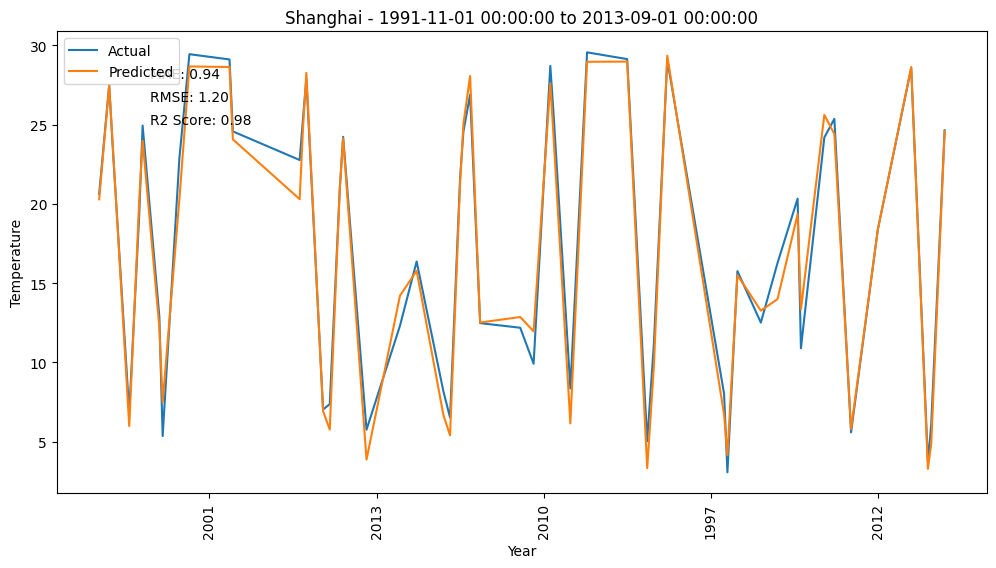

Metrics for Sydney - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.60
RMSE: 0.75
R^2 score: 0.88



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


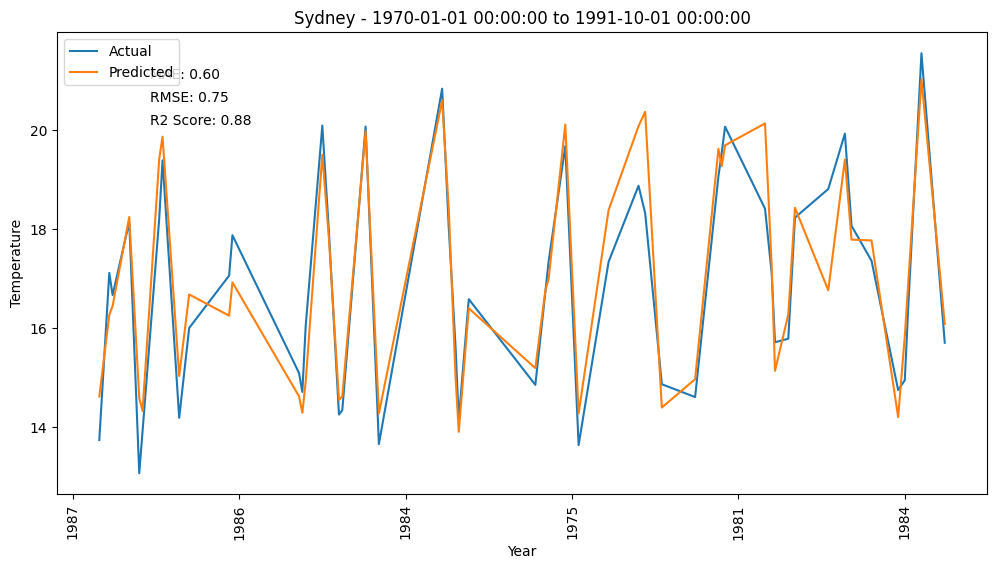

Metrics for Sydney - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.66
RMSE: 0.81
R^2 score: 0.88



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


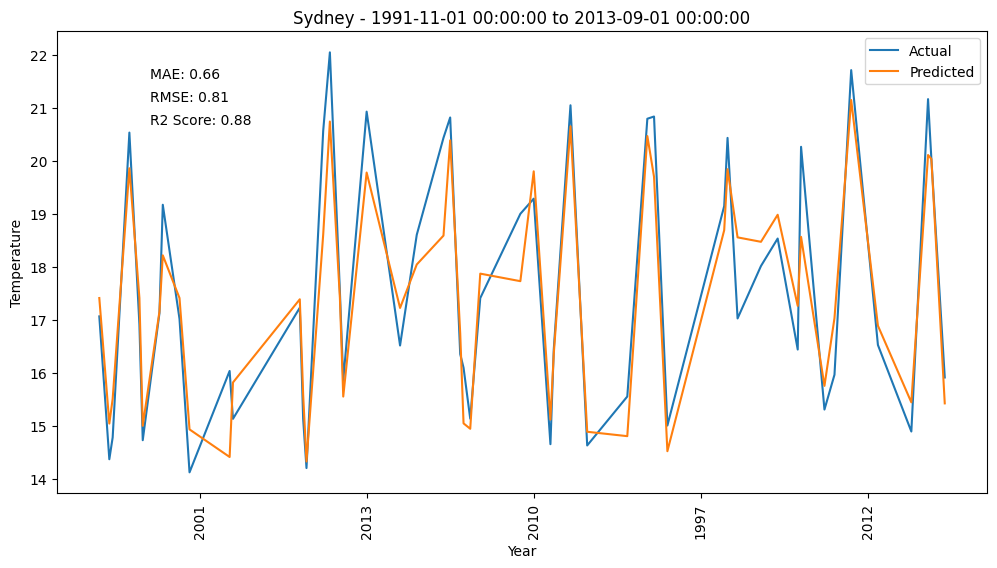

Metrics for São Paulo - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.93
RMSE: 1.13
R^2 score: 0.81



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


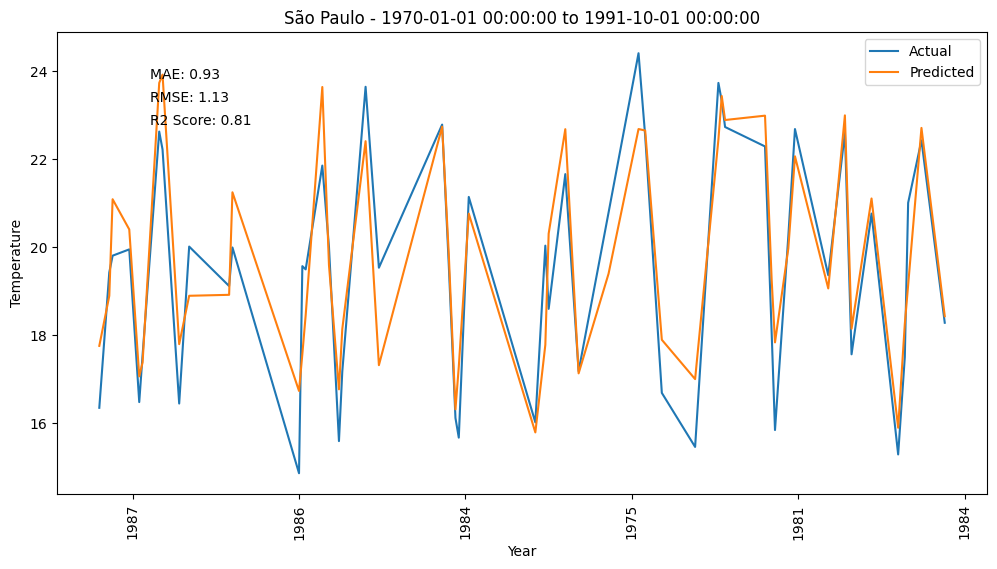

Metrics for São Paulo - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.72
RMSE: 0.99
R^2 score: 0.85



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


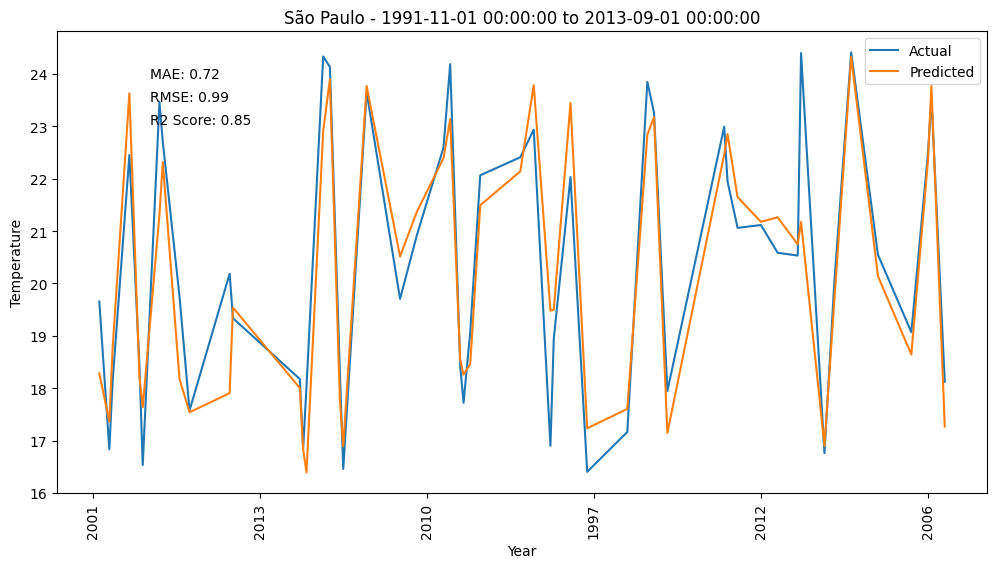

Metrics for Toronto - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.57
RMSE: 2.02
R^2 score: 0.96



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


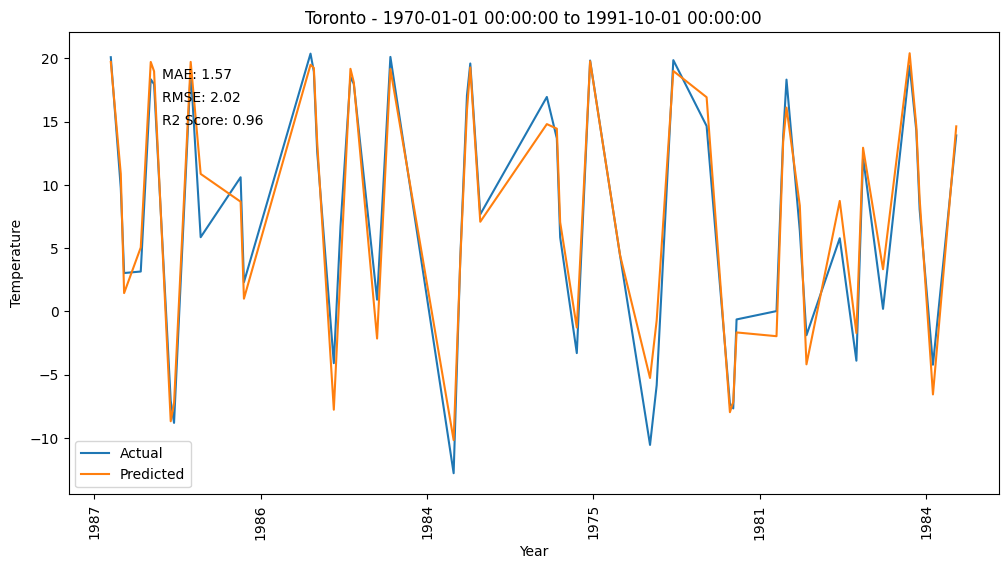

Metrics for Toronto - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.64
RMSE: 2.12
R^2 score: 0.95



<ipython-input-25-06c122a6ee0b>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


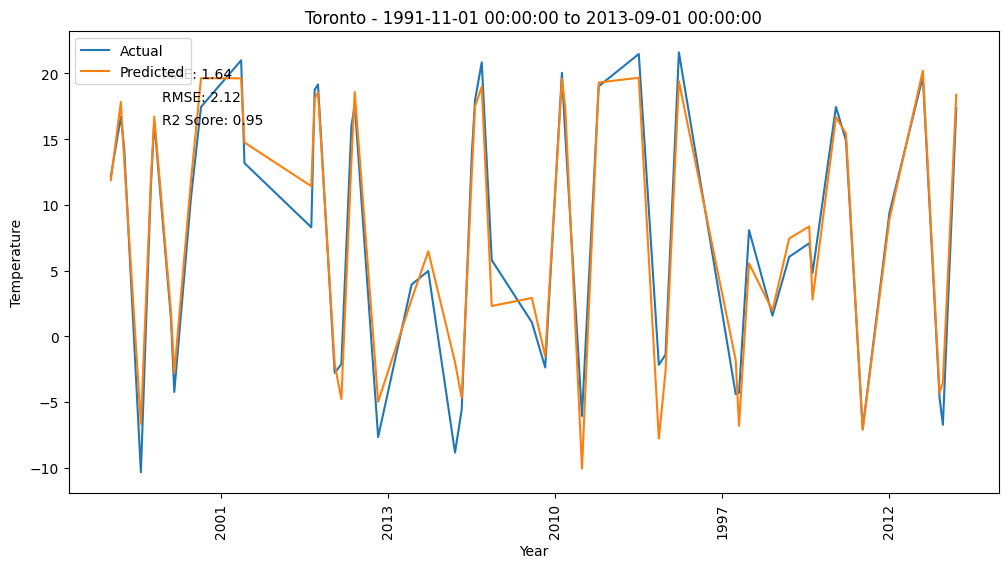

In [ ]:
city_groups = df_city.groupby('City')

for city in city_groups.groups:
    df_city1 = city_groups.get_group(city)

    split_time = df_city1['dt'].iloc[int(len(df_city1)/2)]
    df_city2 = df_city1[df_city1['dt'] < split_time]
    df_city3 = df_city1[df_city1['dt'] >= split_time]

    for df_city_split in [df_city2, df_city3]:
        X = df_city_split[['Year', 'Month']]
        y = df_city_split['AverageTemperature']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        print(f"Metrics for {city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}:")
        print(f"MAE: {mae:.2f}")
        #print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R^2 score: {r2:.2f}\n")

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(x=X_test.index, y=y_test, ax=ax, label='Actual')
        sns.lineplot(x=X_test.index, y=y_pred, ax=ax, label='Predicted')
        ax.set_title(f"{city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}")
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature')
        ax.set_xticklabels(X_test['Year'].values, rotation=90)
        ax.text(0.1, 0.9, f'MAE: {mae:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.85, f'RMSE: {rmse:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.8, f'R2 Score: {r2:.2f}', transform=ax.transAxes)
        plt.show()

## Gradient Boosting Regression (GBR)

Metrics for Bombay - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.45
RMSE: 0.60
R^2 score: 0.85



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


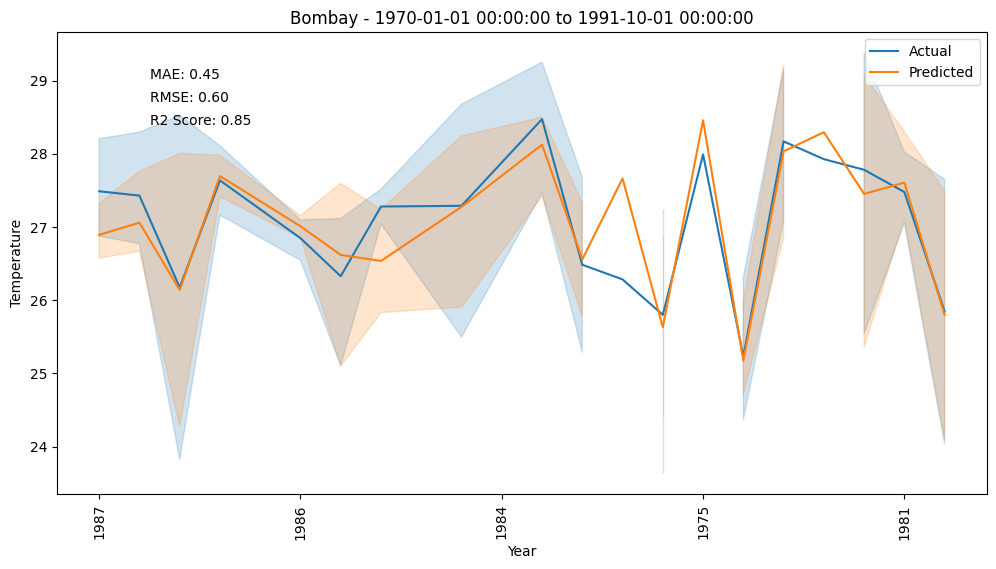

Metrics for Bombay - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.35
RMSE: 0.45
R^2 score: 0.92



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


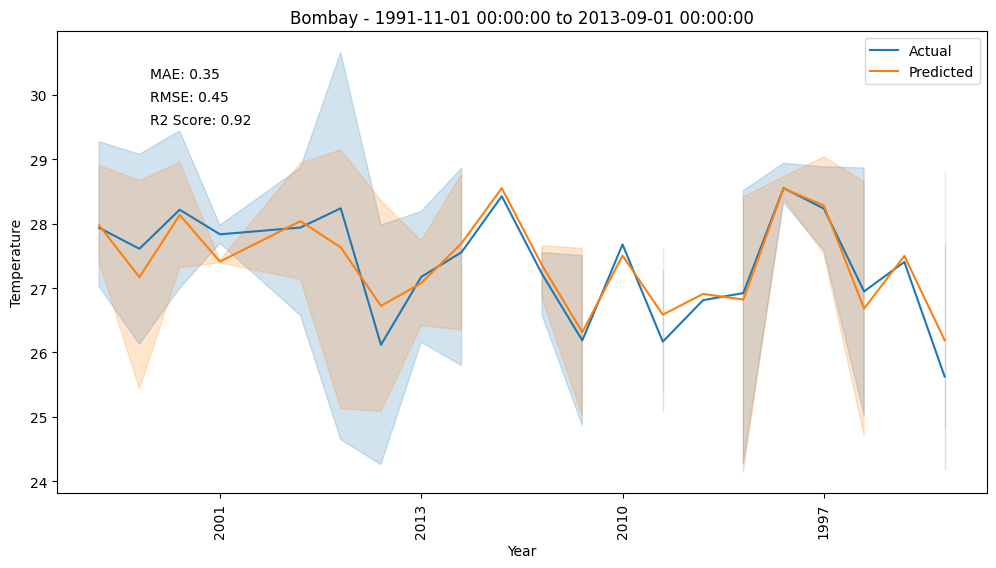

Metrics for Moscow - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.82
RMSE: 2.39
R^2 score: 0.94



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


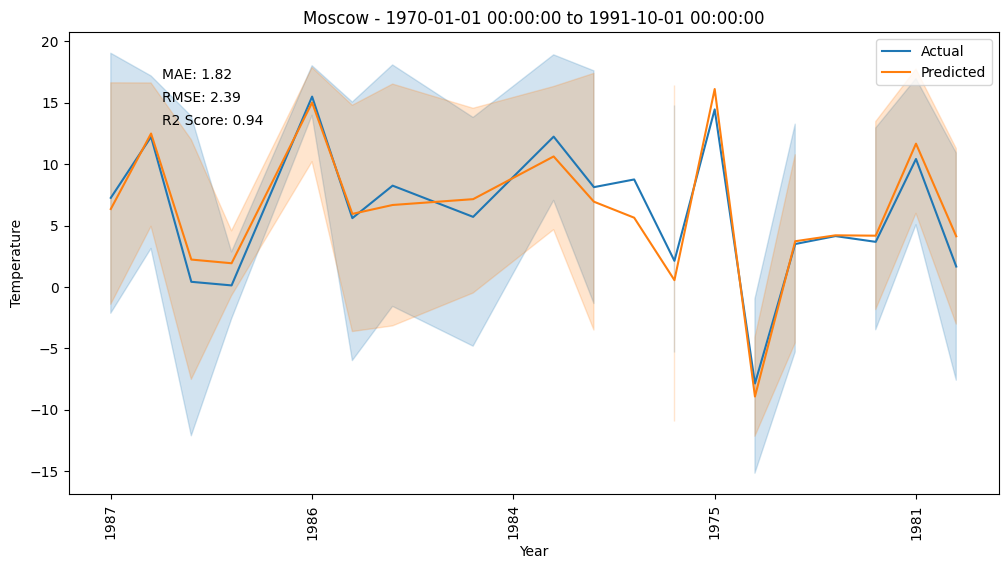

Metrics for Moscow - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.76
RMSE: 2.24
R^2 score: 0.95



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


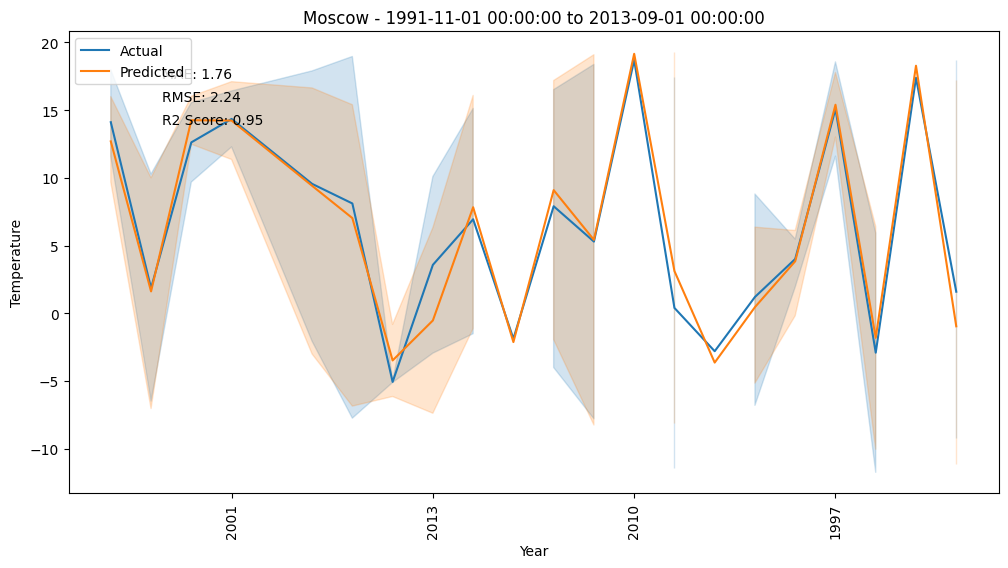

Metrics for New York - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.29
RMSE: 1.79
R^2 score: 0.96



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


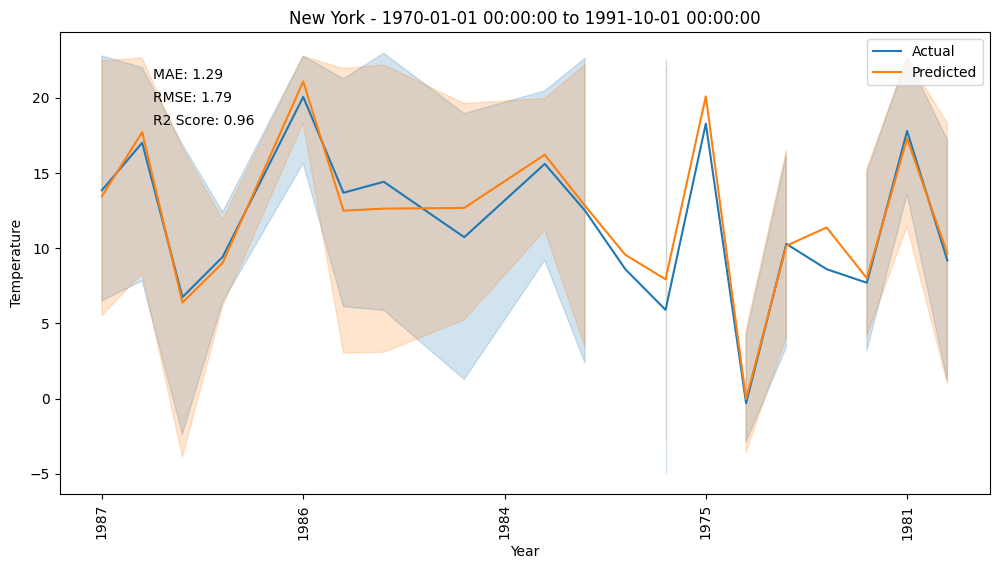

Metrics for New York - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.12
RMSE: 1.48
R^2 score: 0.97



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


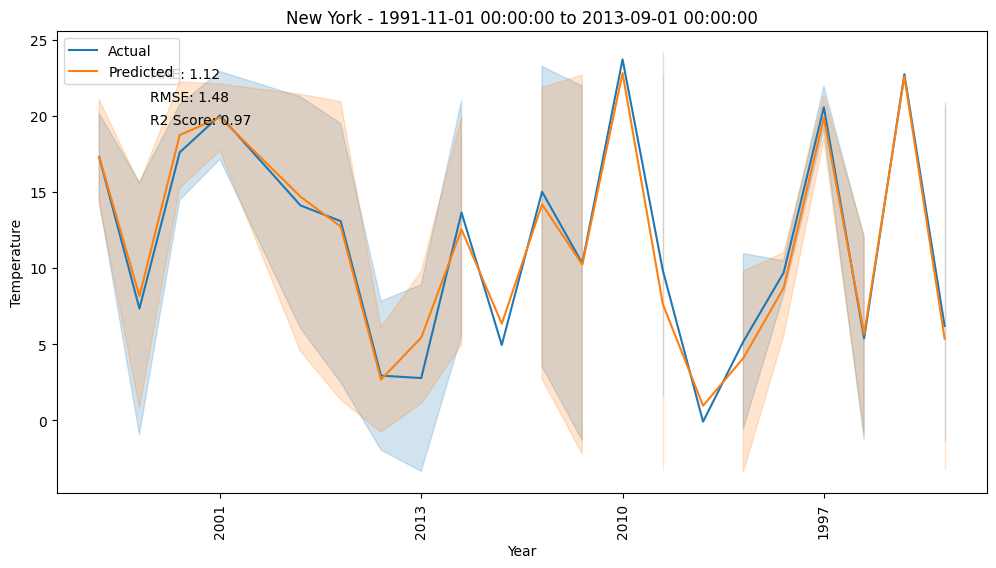

Metrics for Shanghai - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.95
RMSE: 1.18
R^2 score: 0.98



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


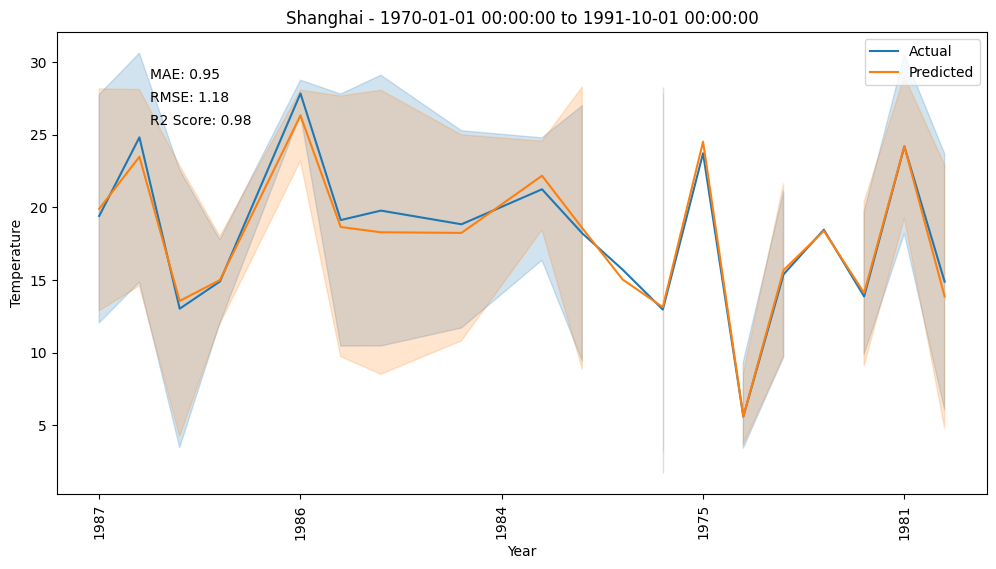

Metrics for Shanghai - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.00
RMSE: 1.17
R^2 score: 0.98



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


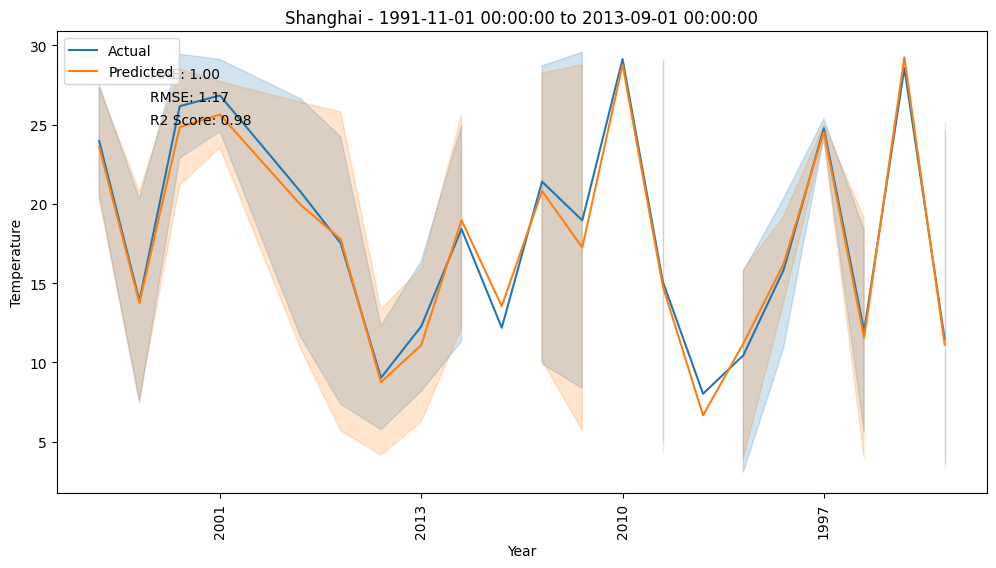

Metrics for Sydney - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.61
RMSE: 0.75
R^2 score: 0.88



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


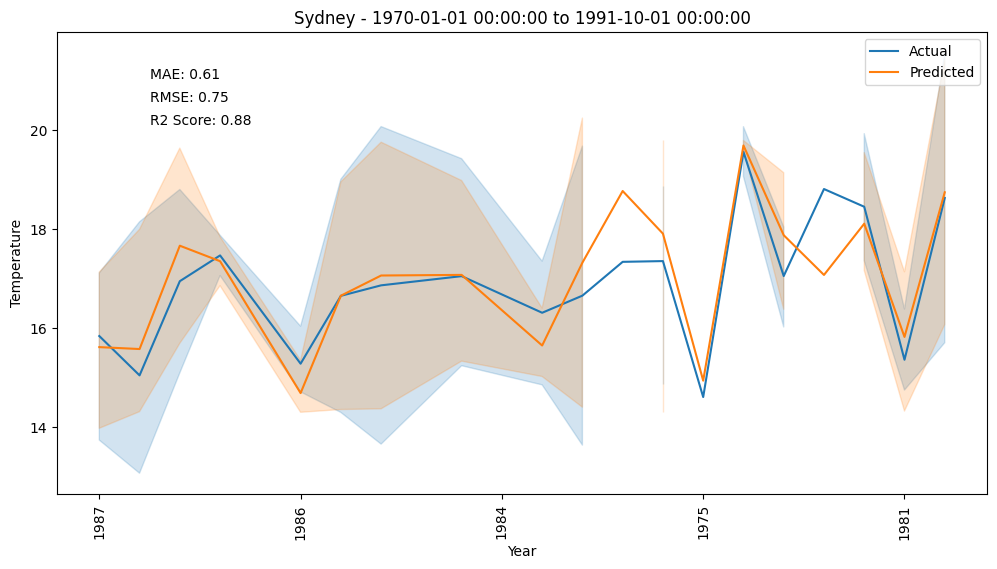

Metrics for Sydney - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.60
RMSE: 0.73
R^2 score: 0.90



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


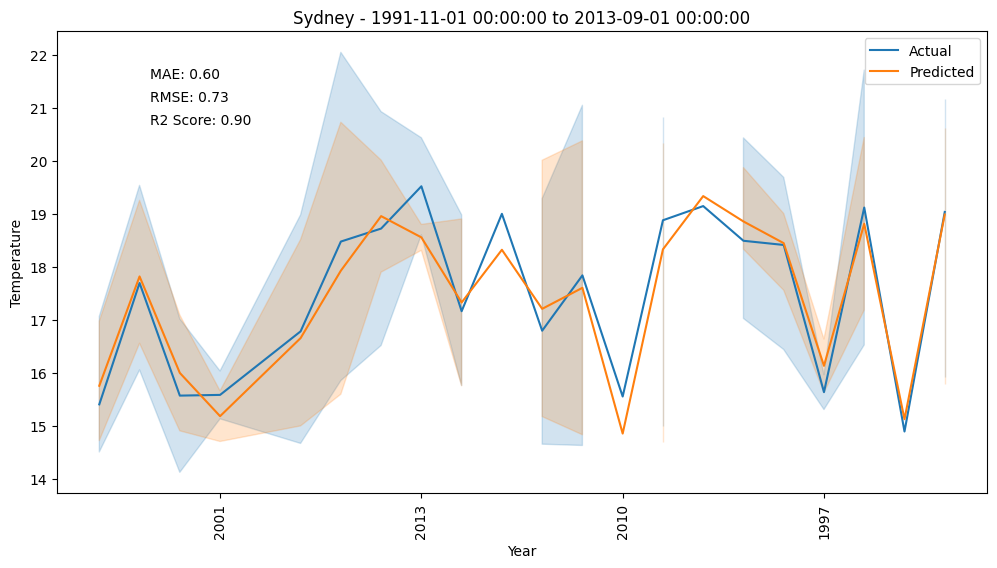

Metrics for São Paulo - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 0.84
RMSE: 1.01
R^2 score: 0.85



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


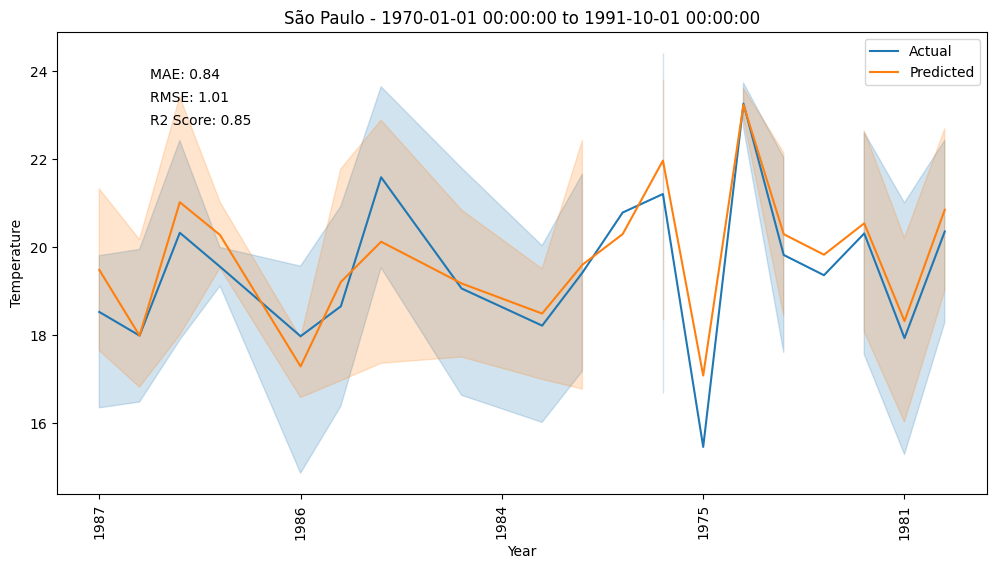

Metrics for São Paulo - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 0.72
RMSE: 0.94
R^2 score: 0.86



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


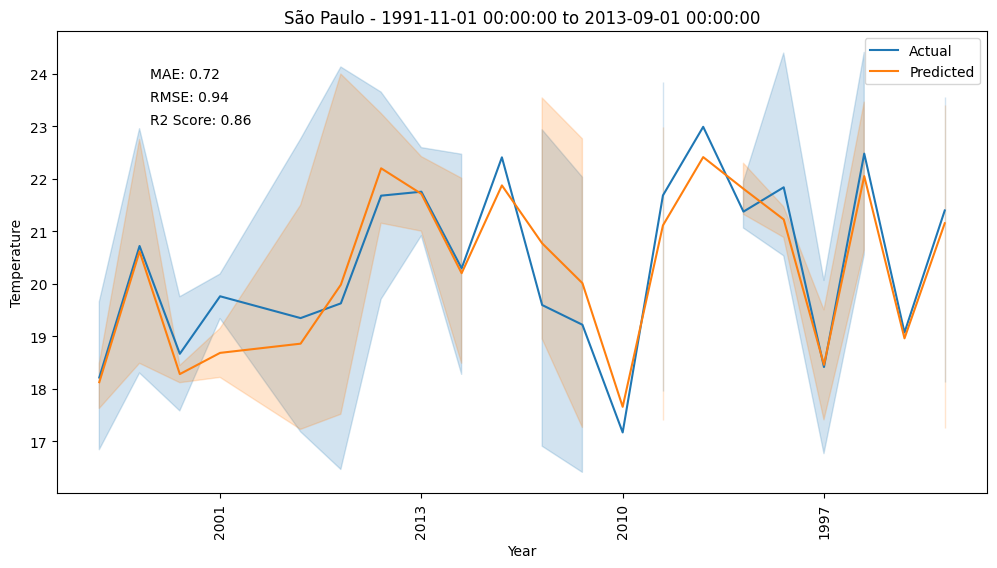

Metrics for Toronto - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.49
RMSE: 1.98
R^2 score: 0.96



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


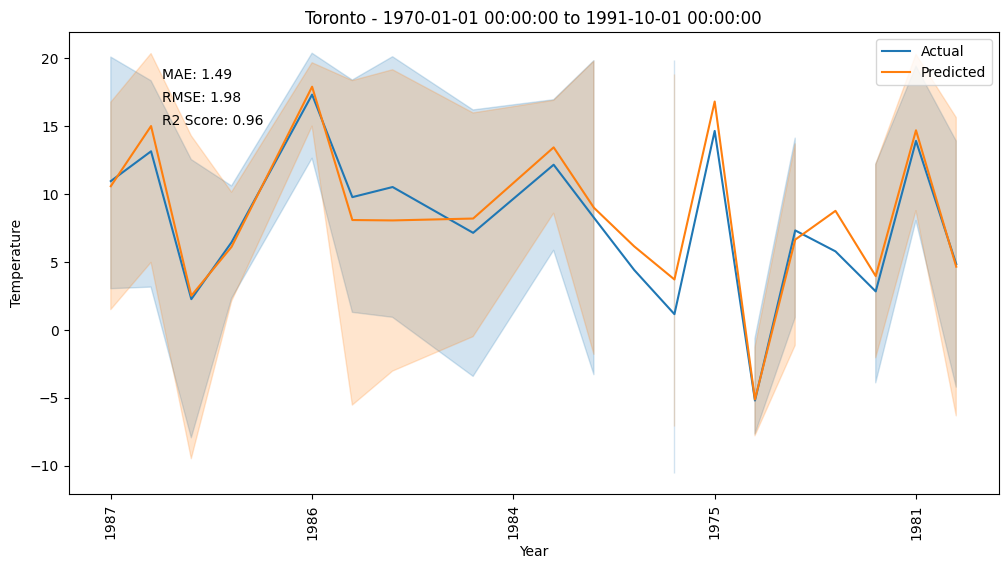

Metrics for Toronto - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.54
RMSE: 2.06
R^2 score: 0.96



<ipython-input-24-4bdae6b1f3c8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_test['Year'].values, rotation=90)


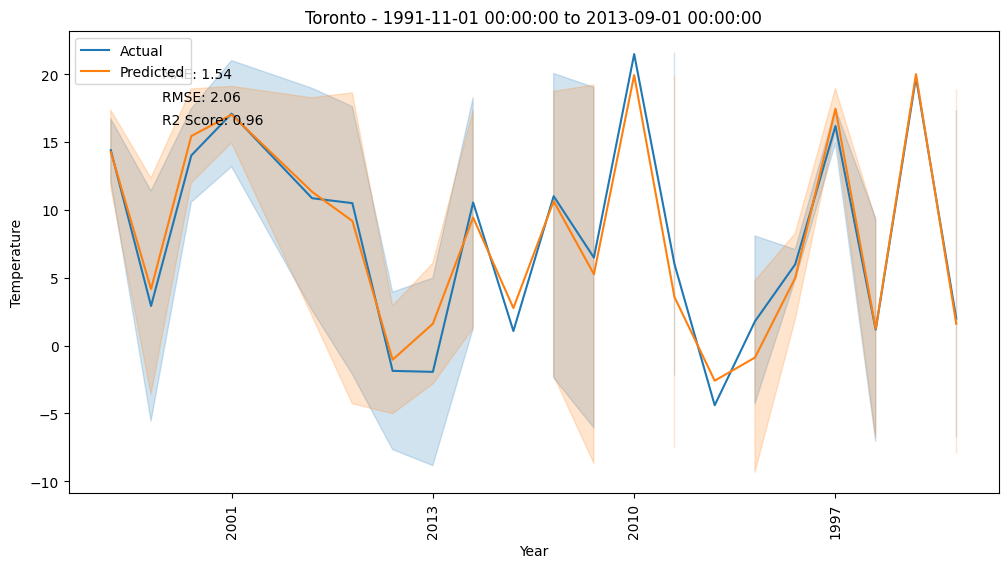

In [ ]:
city_groups = df_city.groupby('City')

for city in city_groups.groups:
    df_city1 = city_groups.get_group(city)

    split_time = df_city1['dt'].iloc[int(len(df_city1)/2)]
    df_city2 = df_city1[df_city1['dt'] < split_time]
    df_city3 = df_city1[df_city1['dt'] >= split_time]

    for df_city_split in [df_city2, df_city3]:
        X = df_city_split[['Year', 'Month']]
        y = df_city_split['AverageTemperature']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
        gb.fit(X_train, y_train)

        y_pred = gb.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        print(f"Metrics for {city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R^2 score: {r2:.2f}\n")

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(x=X_test['Year'], y=y_test, ax=ax, label='Actual')
        sns.lineplot(x=X_test['Year'], y=y_pred, ax=ax, label='Predicted')
        ax.set_title(f"{city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}")
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature')
        ax.set_xticklabels(X_test['Year'].values, rotation=90)
        ax.text(0.1, 0.9, f'MAE: {mae:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.85, f'RMSE: {rmse:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.8, f'R2 Score: {r2:.2f}', transform=ax.transAxes)
        plt.show()


## Lasso Regression

Metrics for Bombay - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.01
RMSE: 1.30
R^2 score: 0.30



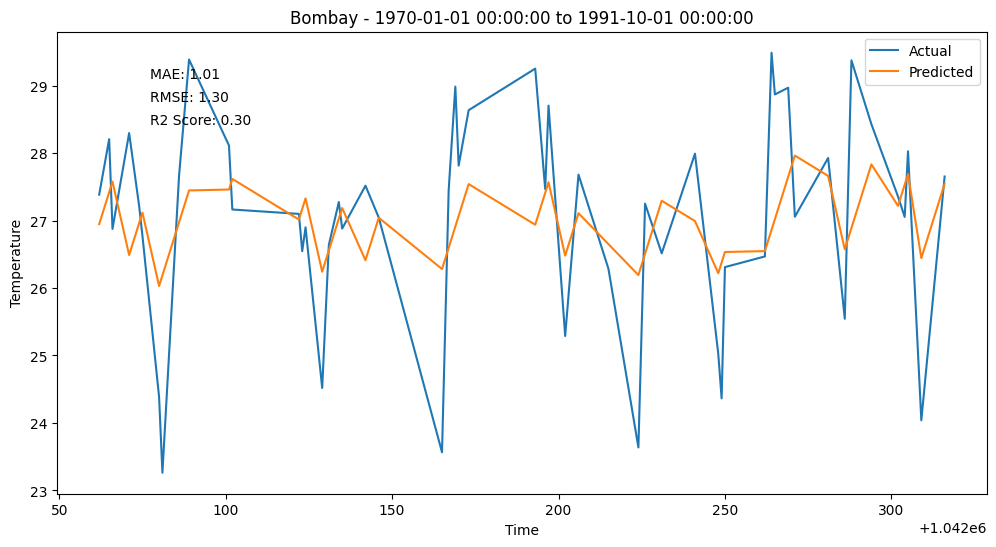

Metrics for Bombay - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.18
RMSE: 1.48
R^2 score: 0.15



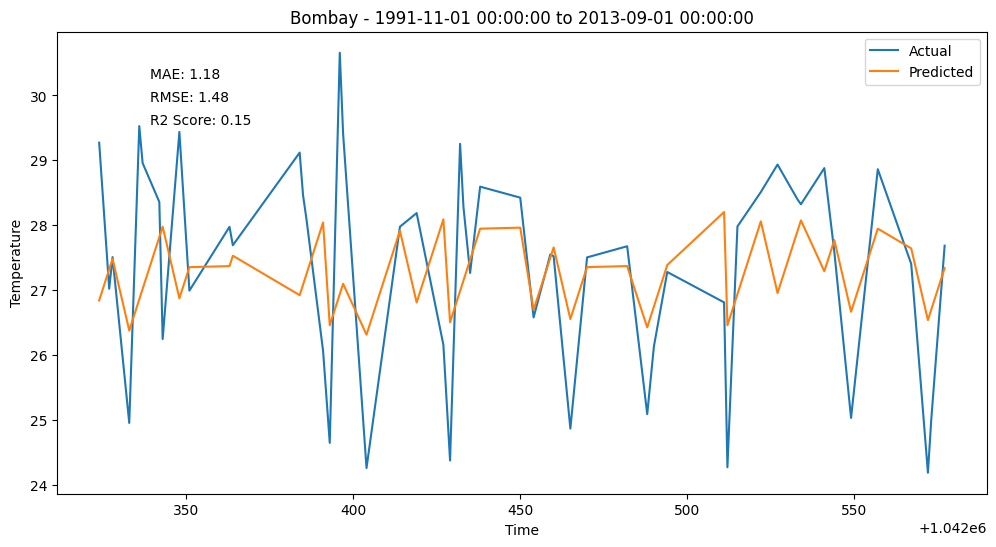

Metrics for Moscow - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 8.40
RMSE: 9.76
R^2 score: 0.07



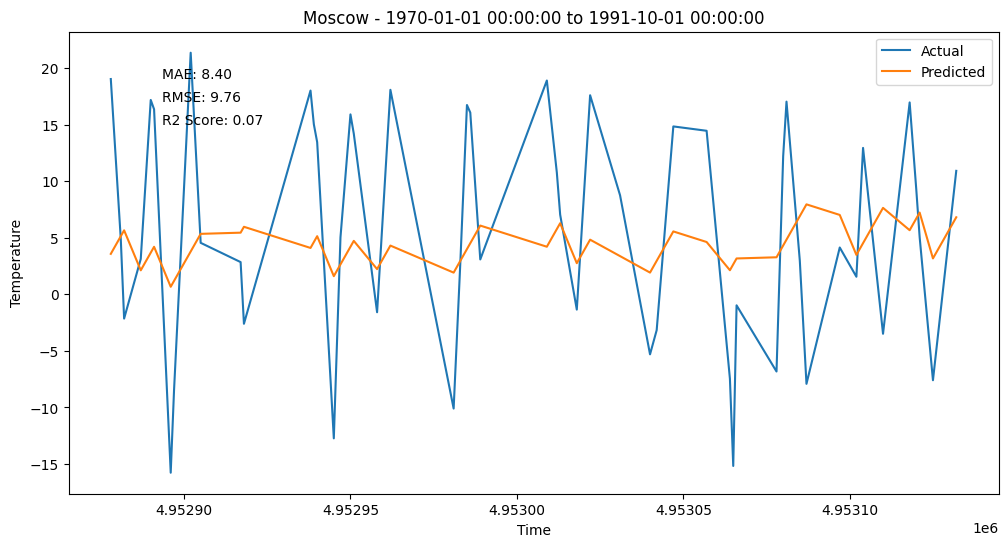

Metrics for Moscow - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 9.71
RMSE: 10.30
R^2 score: -0.01



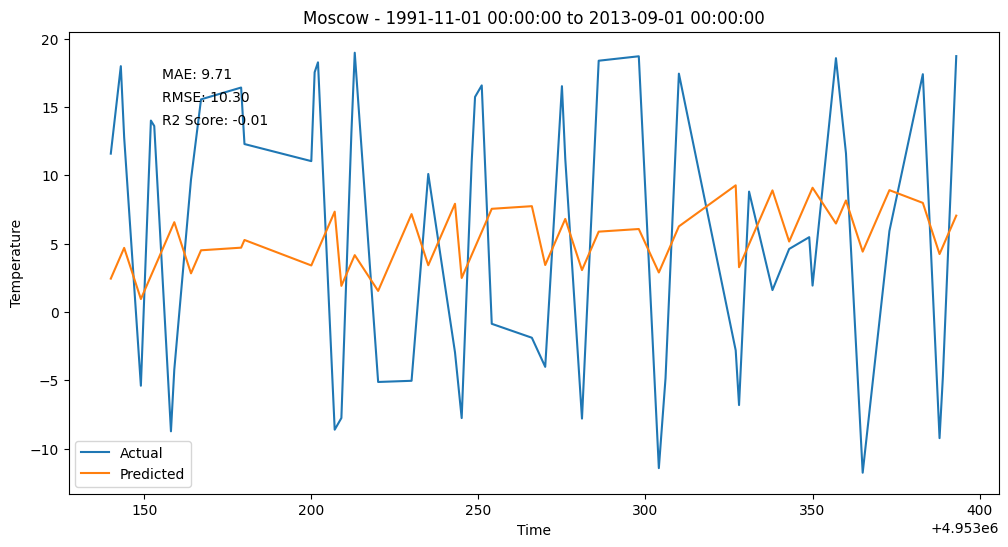

Metrics for New York - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 7.25
RMSE: 8.42
R^2 score: 0.11



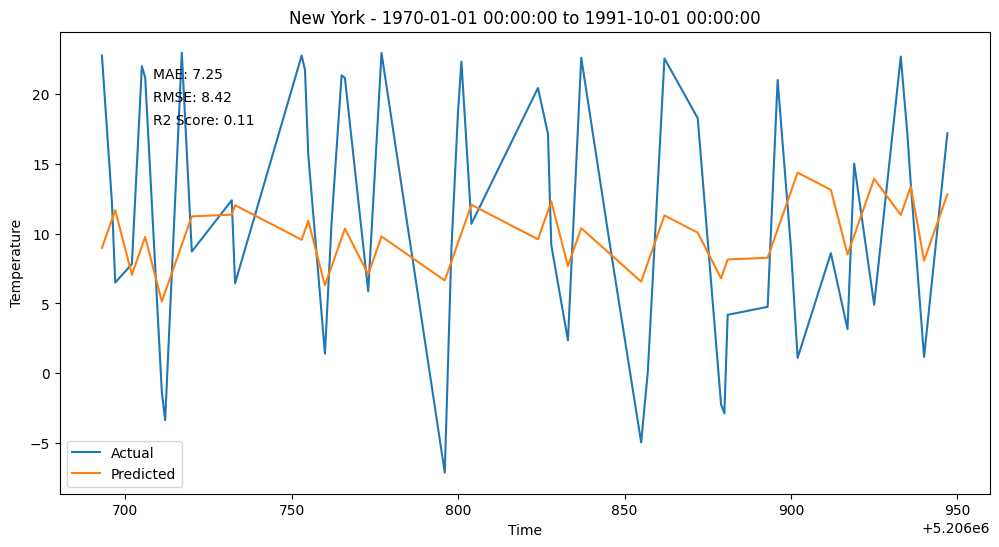

Metrics for New York - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 8.41
RMSE: 9.15
R^2 score: 0.01



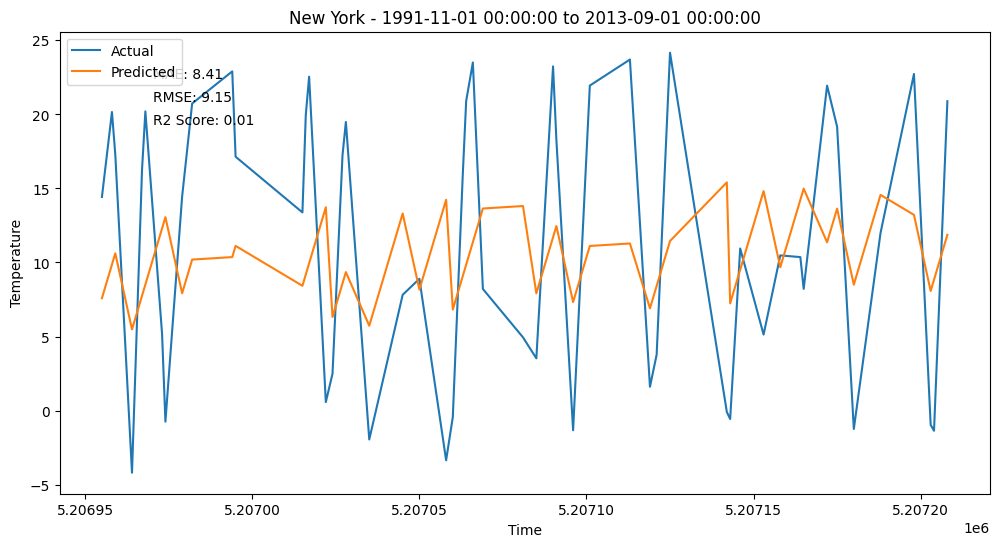

Metrics for Shanghai - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 6.89
RMSE: 8.20
R^2 score: 0.11



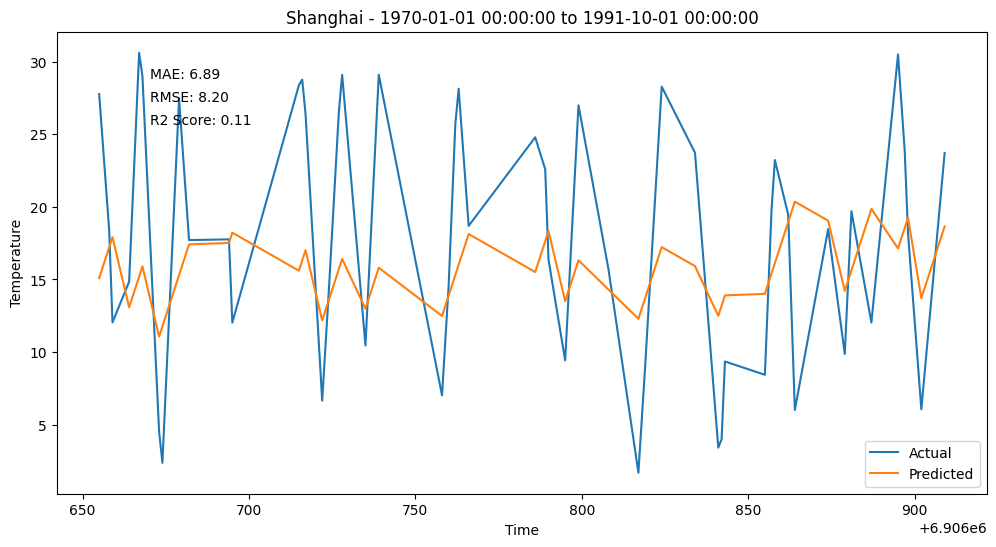

Metrics for Shanghai - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 7.86
RMSE: 8.55
R^2 score: 0.02



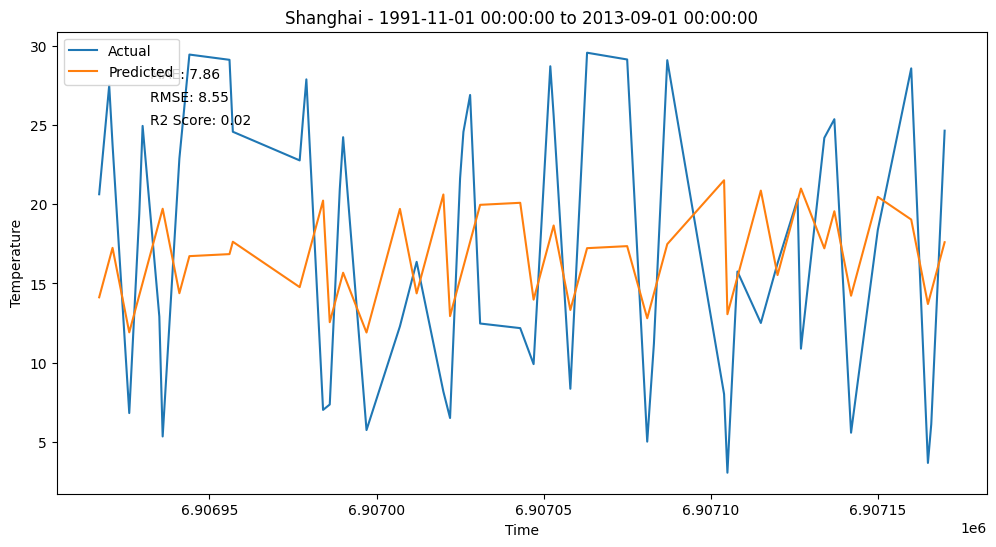

Metrics for Sydney - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 1.55
RMSE: 1.94
R^2 score: 0.18



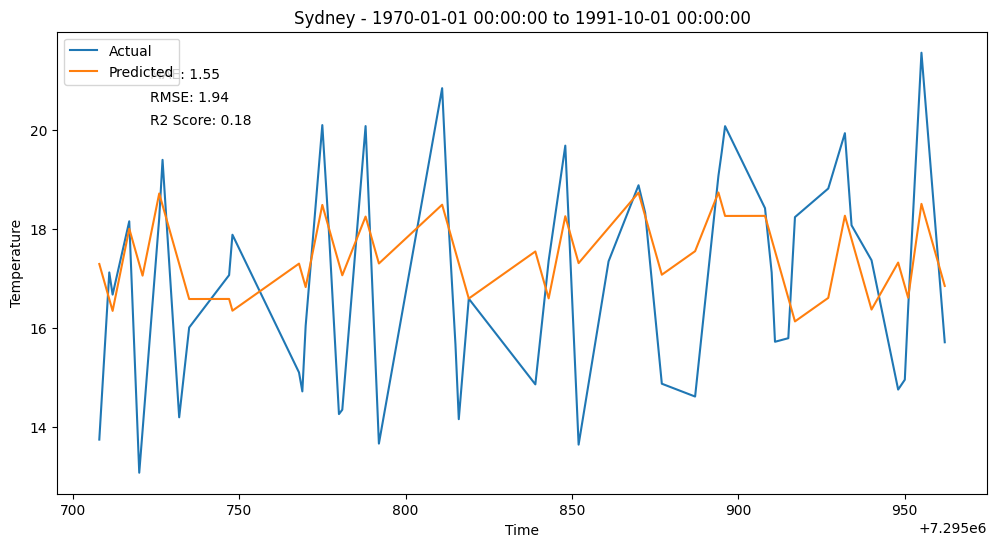

Metrics for Sydney - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 1.88
RMSE: 2.14
R^2 score: 0.17



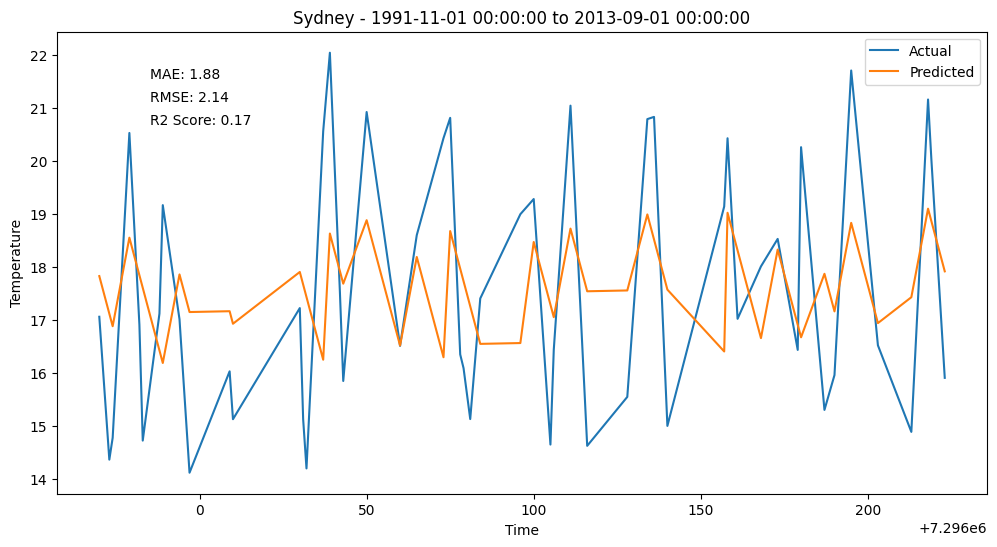

Metrics for São Paulo - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 2.07
RMSE: 2.53
R^2 score: 0.07



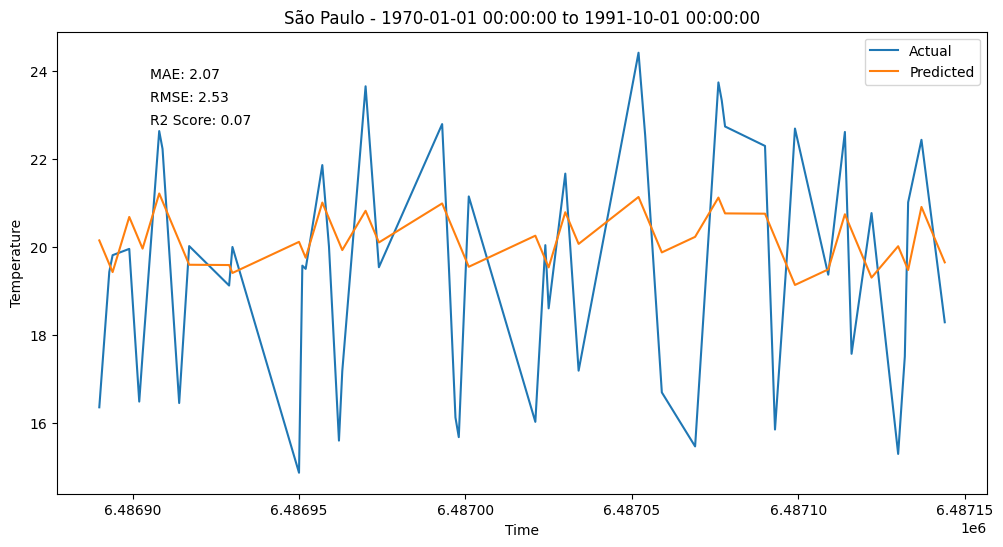

Metrics for São Paulo - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 2.23
RMSE: 2.57
R^2 score: -0.03



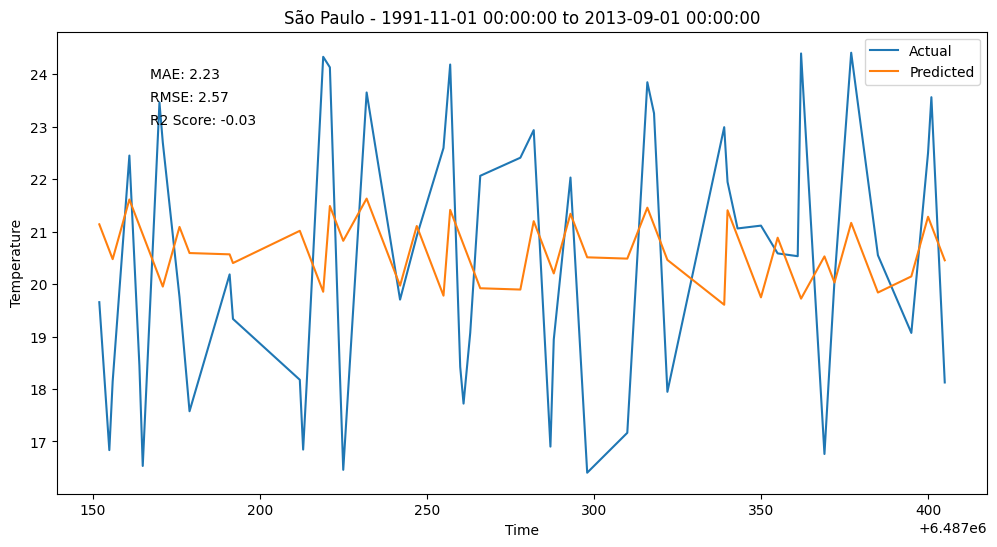

Metrics for Toronto - 1970-01-01 00:00:00 to 1991-10-01 00:00:00:
MAE: 7.97
RMSE: 9.16
R^2 score: 0.14



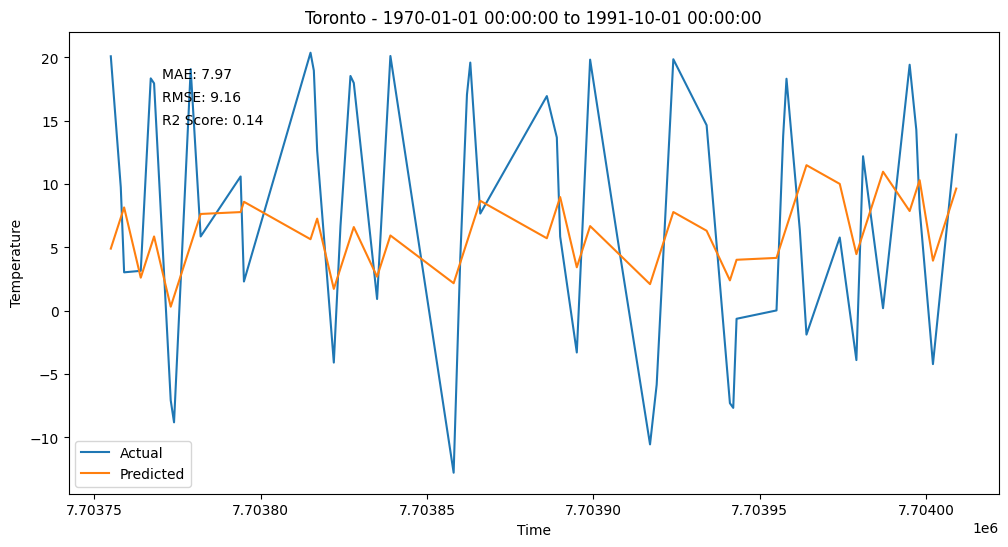

Metrics for Toronto - 1991-11-01 00:00:00 to 2013-09-01 00:00:00:
MAE: 9.02
RMSE: 9.89
R^2 score: 0.01



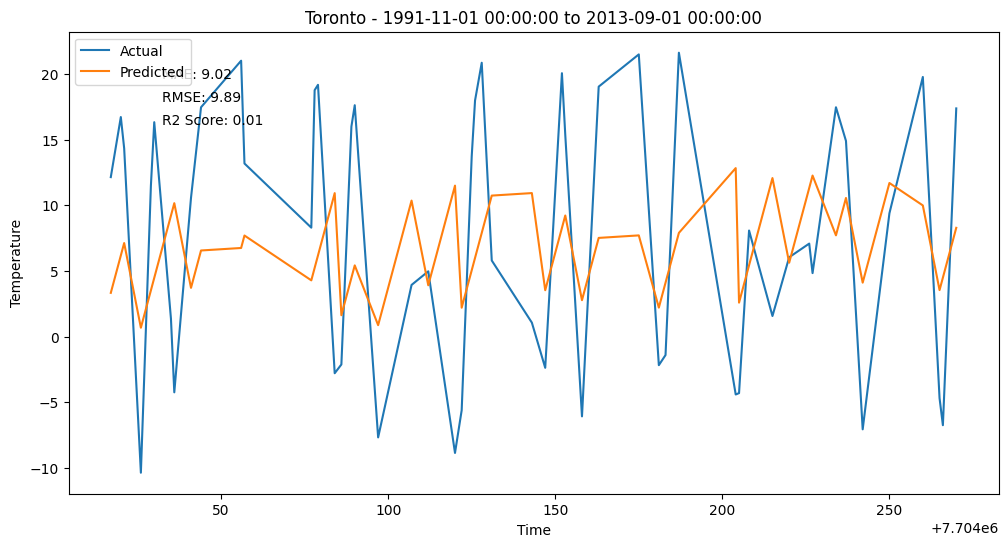

In [ ]:
city_groups = df_city.groupby('City')

for city in city_groups.groups:
    df_city1 = city_groups.get_group(city)

    split_time = df_city1['dt'].iloc[int(len(df_city1)/2)]
    df_city2 = df_city1[df_city1['dt'] < split_time]
    df_city3 = df_city1[df_city1['dt'] >= split_time]

    for df_city_split in [df_city2, df_city3]:
        X = df_city_split[['Year', 'Month']]
        y = df_city_split['AverageTemperature']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        lasso = Lasso(alpha=0.1)
        lasso.fit(X_train, y_train)

        y_pred = lasso.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        print(f"Metrics for {city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R^2 score: {r2:.2f}\n")

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(x=X_test.index, y=y_test, ax=ax, label='Actual')
        sns.lineplot(x=X_test.index, y=y_pred, ax=ax, label='Predicted')
        ax.set_title(f"{city} - {df_city_split.iloc[0]['dt']} to {df_city_split.iloc[-1]['dt']}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Temperature')
        ax.text(0.1, 0.9, f'MAE: {mae:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.85, f'RMSE: {rmse:.2f}', transform=ax.transAxes)
        ax.text(0.1, 0.8, f'R2 Score: {r2:.2f}', transform=ax.transAxes)
        plt.show()


# Clustering

 Split the datset into train,test and validation sets

In [ ]:
stratum = df['Country']
random_seed = 42
df_sample = df.groupby(stratum, group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=random_seed))
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2
train_data, test_data  = train_test_split(df_sample, test_size=test_ratio+val_ratio, random_state=42)
train_data, val_data   = train_test_split(train_data, test_size=val_ratio/(test_ratio+val_ratio), random_state=42)

## KMeans Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Within-Cluster Sum of Squares (WSS) - Training Set: 383019882.0437846
Within-Cluster Sum of Squares (WSS) - Validation Set: 17.464956899937203
Within-Cluster Sum of Squares (WSS) - Test Set: 17.479360421251567


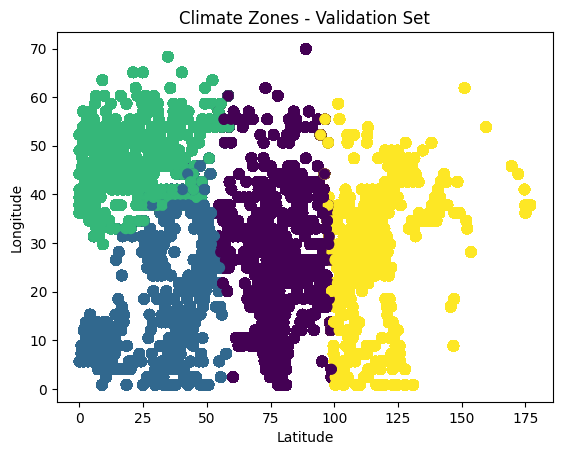

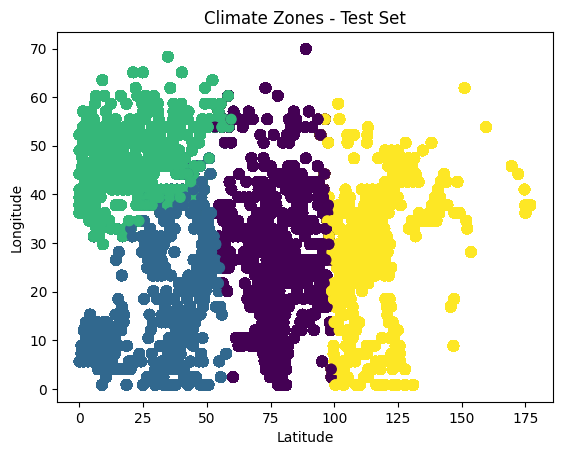

Calinski-Harabasz Index - Training Set: 1567822.4860365319
Calinski-Harabasz Index - Validation Set: 1569640.8193488847
Calinski-Harabasz Index - Test Set: 2090215.5601428647
Davies-Bouldin Index - Training Set: 0.9538093205811329
Davies-Bouldin Index - Validation Set: 0.9522577262359173
Davies-Bouldin Index - Test Set: 0.9535783669398441


In [ ]:
from sklearn.cluster import KMeans
features = ['Latitude', 'Longitude', 'AverageTemperature']
X_train = train_data[features].values
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train)
train_labels = kmeans.labels_

train_wss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WSS) - Training Set:', train_wss)

X_val = val_data[features].values
val_labels = kmeans.predict(X_val)

val_wss = sum(np.min(cdist(X_val, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_val.shape[0]
print('Within-Cluster Sum of Squares (WSS) - Validation Set:', val_wss)

X_test = test_data[features].values
test_labels = kmeans.predict(X_test)
train_data['cluster'] = kmeans.predict(X_train)
val_data['cluster'] = kmeans.predict(X_val)
test_data['cluster'] = kmeans.predict(X_test)

test_wss = sum(np.min(cdist(X_test, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_test.shape[0]
print('Within-Cluster Sum of Squares (WSS) - Test Set:', test_wss)

plt.scatter(X_val[:, 1], X_val[:, 0], c=val_labels, s=50)
plt.title('Climate Zones - Validation Set')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

plt.scatter(X_test[:, 1], X_test[:, 0], c=test_labels, s=50)
plt.title('Climate Zones - Test Set')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

train_ch = calinski_harabasz_score(X_train, train_labels)
print('Calinski-Harabasz Index - Training Set:', train_ch)

val_ch = calinski_harabasz_score(X_val, val_labels)
print('Calinski-Harabasz Index - Validation Set:', val_ch)

test_ch = calinski_harabasz_score(X_test, test_labels)
print('Calinski-Harabasz Index - Test Set:', test_ch)

train_db = davies_bouldin_score(X_train, train_labels)
print('Davies-Bouldin Index - Training Set:', train_db)

val_db = davies_bouldin_score(X_val, val_labels)
print('Davies-Bouldin Index - Validation Set:', val_db)

test_db = davies_bouldin_score(X_test, test_labels)
print('Davies-Bouldin Index - Test Set:', test_db)

## MiniBatchKMeans

The elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

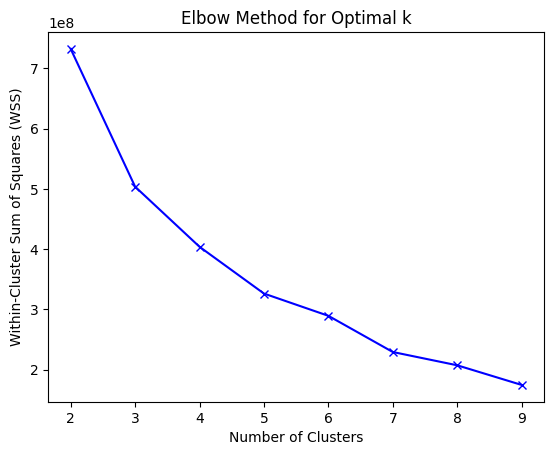

In [ ]:
k_values = range(2,10)
features = ['Latitude', 'Longitude', 'AverageTemperature',"AverageTemperatureUncertainty",]
X_train = train_data[features].values
wss_values = []
for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k , random_state=42)
    kmeans.fit(X_train)
    wss_values.append(kmeans.inertia_)

plt.plot(k_values, wss_values, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

The model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Within-Cluster Sum of Squares (WSS) - Training Set: 402705575.8408018
Within-Cluster Sum of Squares (WSS) - Validation Set: 17.741402816960857
Within-Cluster Sum of Squares (WSS) - Test Set: 17.75196440083742


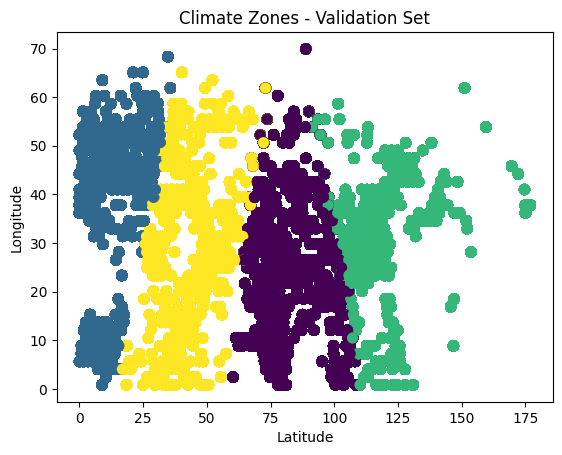

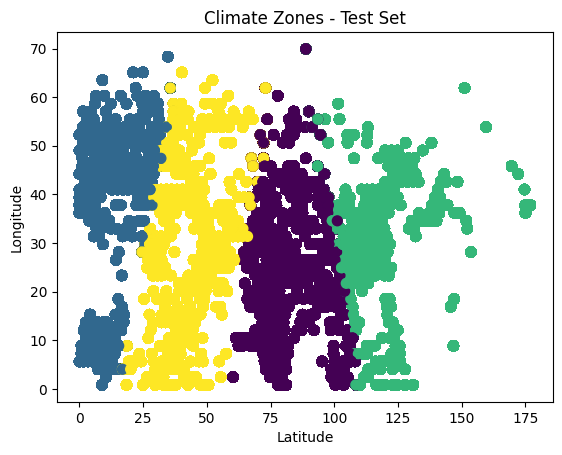

Calinski-Harabasz Index - Training Set: 1475955.9691354835
Calinski-Harabasz Index - Validation Set: 1475877.3014649486
Calinski-Harabasz Index - Test Set: 1966594.4844587562
Davies-Bouldin Index - Training Set: 1.0070011174349516
Davies-Bouldin Index - Validation Set: 1.0063501229513296
Davies-Bouldin Index - Test Set: 1.0074369476069112


In [ ]:

features = ['Latitude', 'Longitude', 'AverageTemperature']
X_train = train_data[features].values
kmeans =MiniBatchKMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train)
train_labels = kmeans.labels_
train_wss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WSS) - Training Set:', train_wss)
X_val = val_data[features].values
val_labels = kmeans.predict(X_val)
val_wss = sum(np.min(cdist(X_val, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_val.shape[0]
print('Within-Cluster Sum of Squares (WSS) - Validation Set:', val_wss)
X_test = test_data[features].values
test_labels = kmeans.predict(X_test)
train_data['cluster'] = kmeans.predict(X_train)
val_data['cluster'] = kmeans.predict(X_val)
test_data['cluster'] = kmeans.predict(X_test)
test_wss = sum(np.min(cdist(X_test, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_test.shape[0]
print('Within-Cluster Sum of Squares (WSS) - Test Set:', test_wss)
plt.scatter(X_val[:, 1], X_val[:, 0], c=val_labels, s=50)
plt.title('Climate Zones - Validation Set')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
plt.scatter(X_test[:, 1], X_test[:, 0], c=test_labels, s=50)
plt.title('Climate Zones - Test Set')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
train_ch = calinski_harabasz_score(X_train, train_labels)
print('Calinski-Harabasz Index - Training Set:', train_ch)

val_ch = calinski_harabasz_score(X_val, val_labels)
print('Calinski-Harabasz Index - Validation Set:', val_ch)

test_ch = calinski_harabasz_score(X_test, test_labels)
print('Calinski-Harabasz Index - Test Set:', test_ch)
train_db = davies_bouldin_score(X_train, train_labels)
print('Davies-Bouldin Index - Training Set:', train_db)

val_db = davies_bouldin_score(X_val, val_labels)
print('Davies-Bouldin Index - Validation Set:', val_db)

test_db = davies_bouldin_score(X_test, test_labels)
print('Davies-Bouldin Index - Test Set:', test_db)
